# Statistical Process Control: CUSUM Chart of Feature

This text explains how to a CUSUM chart can be set up and used.

# Loading modules

Loading the modules we need throughout the notebook and fine-tuning the browser display:

In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:2500px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
import numpy 
import pandas
import os
import sys
import time
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append('..')

# Loading data

As an example, we use data from a sensor ageing data repository.  (v1.0.2) [[Zenodo]](https://doi.org/10.5281/zenodo.3229195). Make sure you have downloaded the file potential_rowB.zip, unzip the contents into a folder of your liking. Then, make sure the folder path in the following cell matches the folder you have chosen:

In [3]:
strFolder = 'C:/G/data/sensorageing/potential_rowB/'

The next lines execute a productivity checks on each data point and select those data point that satisfy these checks.. To enable use of the productivity check, we load all data in a string format. This avoids automatic conversions which may mask some issues with the data.

In [4]:
filename  = Path(strFolder+'rowB_potential_day332.csv')
dfStrData = pandas.read_csv(filepath_or_buffer=filename,delimiter  =';',header =0,dtype=str)
dfStrData.head()

date_time         T1b         T2b         T3b         T4b  \
0  2017.08.31 00:00:01   30.400000    2.700000   -9.300000   48.599998   
1  2017.08.31 00:00:02   30.300001    2.700000   -9.300000   48.599998   
2  2017.08.31 00:00:03   30.400000    2.600000   -9.400000   48.599998   
3  2017.08.31 00:00:04   30.400000    2.700000   -9.400000   48.599998   
4  2017.08.31 00:00:05   30.300001    2.700000   -9.300000   48.599998   

  Unnamed: 5  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

In [5]:
from basic.production import datetimecheck
from basic.typical import typicalitycheck
from basic.production import numericcheck

CheckDT      = datetimecheck(DateTimeFormat='%Y.%m.%d %H:%M:%S')
CheckNUM = numericcheck(NumberFormat='float')

xCheckDT , dtDateTime =  CheckDT(DateTimeEntry=dfStrData['date_time'])
xCheckNUM1 , rValue1 = CheckNUM(NumberEntry=dfStrData['T1b'])
xCheckNUM2 , rValue2 = CheckNUM(NumberEntry=dfStrData['T2b'])
xCheckNUM3 , rValue3 = CheckNUM(NumberEntry=dfStrData['T3b'])
xCheckNUM4 , rValue4 = CheckNUM(NumberEntry=dfStrData['T4b'])

xInclude = numpy.all([xCheckDT,xCheckNUM1,xCheckNUM2,xCheckNUM3,xCheckNUM4],axis=0)

dtDateTime=numpy.array(dtDateTime)
rValue1=numpy.array(rValue1)
rValue2=numpy.array(rValue2)
rValue3=numpy.array(rValue3)
rValue4=numpy.array(rValue4)
dtDateTime=dtDateTime[xInclude]
rValue1=rValue1[xInclude]
rValue2=rValue2[xInclude]
rValue3=rValue3[xInclude]
rValue4=rValue4[xInclude]

The selected feature is the difference between two sensor signals, e.g. between the signal of sensor 4 and 3:

In [6]:
ytil = rValue4-rValue3

# Phase I: Compute location and spread

We plot the first 10000 data points, which will be used to identify the model (location / spread)

C:\ProgramData\Anaconda3_1\envs\ATK\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


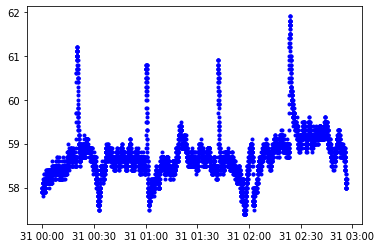

In [7]:
N1 = 10000

plt.plot(dtDateTime[0:N1],ytil[0:N1],'b.')

We compute the location (in this case: the median) and the spread (in this case: median absolute deviation)

In [8]:
mu_hat = numpy.median(ytil[0:N1])
sigma_hat = numpy.median(numpy.abs(ytil[0:N1]-mu_hat))

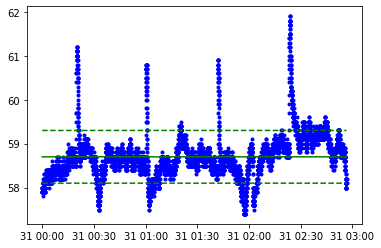

In [9]:

plt.plot(dtDateTime[0:N1],ytil[0:N1],'b.')
plt.plot(dtDateTime[0:N1],mu_hat*numpy.ones(N1),'g-')
plt.plot(dtDateTime[0:N1],(mu_hat+3*sigma_hat)*numpy.ones(N1),'g--')
plt.plot(dtDateTime[0:N1],(mu_hat-3*sigma_hat)*numpy.ones(N1),'g--')


# Phase II: Predict + Compare

In [10]:
N2=len(dtDateTime)-N1
Kpar = 5

yhat_pos = numpy.nan*numpy.ones(N2)
yhat_neg = numpy.nan*numpy.ones(N2)

yhat_pos_k = mu_hat
yhat_neg_k = mu_hat
for k,ytil_k in enumerate(ytil[N1:]):
    yhat_pos_k = numpy.maximum(mu_hat,yhat_pos_k+(ytil_k-mu_hat)-Kpar)
    yhat_pos[k] = yhat_pos_k
    yhat_neg_k = numpy.minimum(mu_hat,yhat_neg_k+(ytil_k-mu_hat)+Kpar)
    yhat_neg[k] = yhat_neg_k

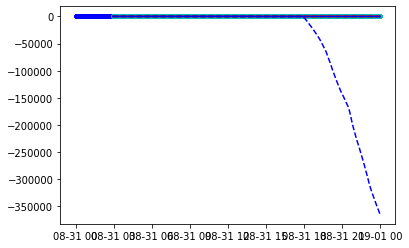

In [11]:

plt.plot(dtDateTime[0:N1],ytil[0:N1],'b.')
plt.plot(dtDateTime[N1:],ytil[N1:],'c.')
plt.plot(dtDateTime[N1:],mu_hat*numpy.ones(N2),'g-')
plt.plot(dtDateTime[N1:],(mu_hat+3*sigma_hat)*numpy.ones(N2),'g--')
plt.plot(dtDateTime[N1:],(mu_hat-3*sigma_hat)*numpy.ones(N2),'g--')
plt.plot(dtDateTime[N1:],mu_hat*numpy.ones(N2),'r-')
plt.plot(dtDateTime[N1:],(mu_hat+5*sigma_hat)*numpy.ones(N2),'r--')
plt.plot(dtDateTime[N1:],(mu_hat-5*sigma_hat)*numpy.ones(N2),'r--')
plt.plot(dtDateTime[N1:],yhat_pos,'b-')
plt.plot(dtDateTime[N1:],yhat_neg,'b--')
#plt.xlim([dtDateTime[N1-60],dtDateTime[N1+120]])
#plt.ylim([0,120])
#plt.xlim([dtDateTime[N1],dtDateTime[N1+60]])
#plt.plot(dtDateTime[N1:],(mu_hat+11*sigma_hat)*numpy.ones(N2),'r-')
#plt.plot(dtDateTime[N1:],(mu_hat-11*sigma_hat)*numpy.ones(N2),'r-')


Now let's inspect the original signals of the two sensors used to compute the feature (or of all four sensors)

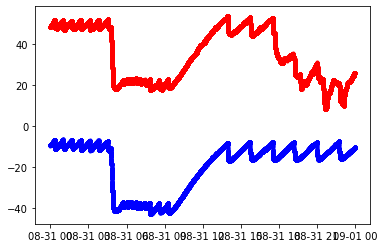

In [12]:
#plt.plot(dtDateTime,rValue1,'k.')
#plt.plot(dtDateTime,rValue2,'g.')
plt.plot(dtDateTime,rValue3,'b.')
plt.plot(dtDateTime,rValue4,'r.')